In [ ]:
# Step1:Load the dataset
import pandas as pd
file_path = "HEART_ATTACK_PREDICTION_DATASET.csv"
data = pd.read_csv(file_path)

# Display the first few rows
print(data.head())


  Patient ID  Age     Sex  Cholesterol Blood Pressure  Heart Rate  Diabetes  \
0    BMW7812   67    Male          208         158/88          72         0   
1    CZE1114   21    Male          389         165/93          98         1   
2    BNI9906   21  Female          324         174/99          72         1   
3    JLN3497   84    Male          383         163100          73         1   
4    GFO8847   66    Male          318          91/88          93         1   

   Family History  Smoking  Obesity  ...  Sedentary Hours Per Day  Income  \
0               0        1        0  ...                 6.615001  261404   
1               1        1        1  ...                 4.963459  285768   
2               0        0        0  ...                 9.463426  235282   
3               1        1        0  ...                 7.648981  125640   
4               1        1        1  ...                 1.514821  160555   

         BMI  Triglycerides  Physical Activity Days Per Week  

In [ ]:
#import required library
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.combine import SMOTEENN
from tensorflow.keras.models import Sequential
from sklearn.utils import shuffle
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras_tuner.tuners import Hyperband
import warnings

warnings.filterwarnings("ignore")

In [ ]:
#Step 2: Data Cleaning
data['Sex'] = data['Sex'].map({'Male': 1, 'Female': 0})
data['Diet'] = data['Diet'].map({'Healthy': 3, 'Average': 2, 'Unhealthy': 1})

# Splitting 'Blood Pressure' into 'Systolic' and 'Diastolic'
data[['Systolic', 'Diastolic']] = data['Blood Pressure'].str.split('/', expand=True).astype(float)
data.drop(['Blood Pressure', 'Patient ID', 'Country', 'Continent', 'Hemisphere'], axis=1, inplace=True)

# Filling Missing Values
data.fillna(data.median(), inplace=True)

# Features and Target Variable
X = data.drop('Heart Attack Risk', axis=1)
y = data['Heart Attack Risk']

# Handle Class Imbalance using SMOTEENN
smote_enn = SMOTEENN(random_state=42)
X_resampled, y_resampled = smote_enn.fit_resample(X, y)

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Standardizing Data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
#build the model and add early stopping

def build_model(input_dim, learning_rate=0.001, reg_strength=0.01, dropout_rate=0.3):
    model = Sequential([
        Dense(128, activation='relu', input_dim=input_dim, kernel_regularizer=l2(reg_strength)),
        Dropout(dropout_rate),
        Dense(64, activation='relu', kernel_regularizer=l2(reg_strength)),
        Dropout(dropout_rate),
        Dense(1, activation='sigmoid')
    ])
    
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model



In [16]:
model = build_model(input_dim=X_train_scaled.shape[1])
model.summary()
def get_callbacks():
    return [
        EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
    ]


callbacks = get_callbacks()
history = model.fit(
    X_train_scaled, y_train,
    epochs=100,
    validation_split=0.2,
    callbacks=callbacks,
    verbose=1
)

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                 │ (None, 128)            │         2,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,265 (44.00 KB)

 Trainable params: 11,265 (44.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.5667 - loss: 1.8064 - val_accuracy: 0.6566 - val_loss: 1.3998
Epoch 2/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6616 - loss: 1.3338 - val_accuracy: 0.6623 - val_loss: 1.1034
Epoch 3/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6295 - loss: 1.0854 - val_accuracy: 0.6679 - val_loss: 0.9349
Epoch 4/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6445 - loss: 0.9151 - val_accuracy: 0.6811 - val_loss: 0.8168
Epoch 5/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6746 - loss: 0.8093 - val_accuracy: 0.6774 - val_loss: 0.7469
Epoch 6/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6621 - loss: 0.7456 - val_accuracy: 0.6792 - val_loss: 0.7065
Epoch 7/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6721 - loss: 0.7031 - val_accuracy: 0.6981 - val_loss: 0.6732
Epoch 8/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6815 - loss: 0.6822 - val_accuracy: 0.6660 - 

Test Accuracy: 66.16%
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.51      0.56       284
           1       0.68      0.78      0.72       378

    accuracy                           0.66       662
   macro avg       0.65      0.64      0.64       662
weighted avg       0.66      0.66      0.66       662



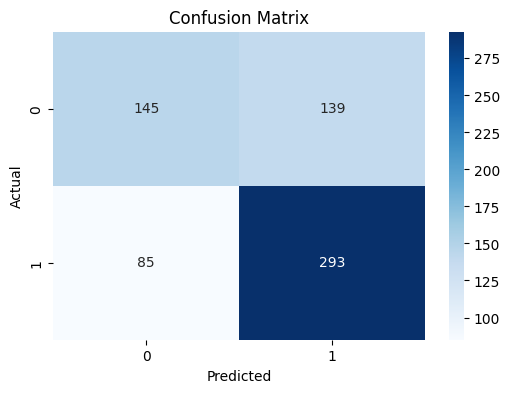

In [17]:
# Evaluate on Test Data
test_loss, test_accuracy = model.evaluate(X_test_scaled, y_test, verbose=0)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# Predictions
y_pred = (model.predict(X_test_scaled) > 0.5).astype(int)

# Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


### To improve the moodel accuracy lets add hyperparameter tuning

In [ ]:
# Hyperparameter Tuning
# from tensorflow.keras.layers import BatchNormalization, LeakyReLU

# Define an Enhanced Model
def create_improved_model():
    model = Sequential([
        Dense(256, kernel_regularizer=l2(0.01), input_dim=X_train_scaled.shape[1]),
        BatchNormalization(),
        LeakyReLU(alpha=0.1),
        Dropout(0.3),
        Dense(128, kernel_regularizer=l2(0.01)),
        BatchNormalization(),
        LeakyReLU(alpha=0.1),
        Dropout(0.3),
        Dense(64, kernel_regularizer=l2(0.01)),
        BatchNormalization(),
        LeakyReLU(alpha=0.1),
        Dropout(0.2),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model


# Hyperparameter Tuning
tuner = Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=10,
    factor=3,
    directory='my_dir',
    project_name='heart_attack_tuning'
)

tuner.search(X_train_scaled, y_train, validation_split=0.2, epochs=10, verbose=1)

# Best Hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"""
Best Units: {best_hps.get('units')}
Best Dropout: {best_hps.get('dropout')}
Best Learning Rate: {best_hps.get('learning_rate')}
""")


Reloading Tuner from my_dir\heart_attack_tuning\tuner0.json

Best Units: 256
Best Dropout: 0.2
Best Learning Rate: 0.001



In [ ]:
# Define the function to add Gaussian noise
def add_gaussian_noise(data, mean=0, std=1):
    noise = np.random.normal(mean, std, data.shape)
    noisy_data = data + noise
    return noisy_data           

# Augment full training set with noisy data
X_train_noisy = add_gaussian_noise(X_train_scaled, mean=0, std=0.01)  # Add noise with std=0.01
X_train_aug = np.vstack((X_train_scaled, X_train_noisy))  # Combine original and noisy data
y_train_aug = np.hstack((y_train, y_train))  # Duplicate the target labels for the augmented data
X_train_aug, y_train_aug = shuffle(X_train_aug, y_train_aug, random_state=42)  # Shuffle to mix data

# Cross-Validation Setup
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_accuracies = []

# Number of models for the ensemble
n_models = 3
models = []

# Define EarlyStopping and LearningRateScheduler
def get_callbacks():
    return [
        EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
    ]

# Perform cross-validation and train models
for train_idx, val_idx in kf.split(X_train_aug, y_train_aug):
    # Splitting the data for cross-validation fold
    X_train_fold, X_val_fold = X_train_aug[train_idx], X_train_aug[val_idx]
    y_train_fold, y_val_fold = y_train_aug[train_idx], y_train_aug[val_idx]

    # Scale data
    scaler = StandardScaler()
    X_train_fold_scaled = scaler.fit_transform(X_train_fold)
    X_val_fold_scaled = scaler.transform(X_val_fold)

    # Train multiple models for each fold
    for i in range(n_models):
        print(f"\nTraining model {i+1}/{n_models} on fold {len(cv_accuracies)+1}")
        # Assuming create_improved_model() is defined elsewhere (e.g., returns a Keras model)
        model = create_improved_model()

        # Train the model
        history = model.fit(
            X_train_fold_scaled, y_train_fold,
            validation_data=(X_val_fold_scaled, y_val_fold),
            epochs=50,
            batch_size=32,
            callbacks=get_callbacks(),  # Add the callback here
            verbose=1
        )

        # Evaluate fold accuracy
        _, fold_acc = model.evaluate(X_val_fold_scaled, y_val_fold, verbose=0)
        cv_accuracies.append(fold_acc)
        models.append(model)

# Output cross-validation results
print(f"Cross-Validation Mean Accuracy: {np.mean(cv_accuracies) * 100:.2f}%")

# Ensemble Predictions (using the trained models)
ensemble_preds = np.mean([model.predict(X_test_scaled) for model in models], axis=0)

# Convert to binary predictions (assuming it's a binary classification task)
ensemble_preds = (ensemble_preds > 0.5).astype(int)

# Final evaluation with classification report
print("\nEnsemble Classification Report:")
print(classification_report(y_test, ensemble_preds))



Training model 1/3 on fold 1
Epoch 1/50
133/133 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.5818 - loss: 3.3072 - val_accuracy: 0.6591 - val_loss: 2.2786
Epoch 2/50
133/133 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.6610 - loss: 2.0996 - val_accuracy: 0.6449 - val_loss: 1.6223
Epoch 3/50
133/133 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.6681 - loss: 1.5135 - val_accuracy: 0.6383 - val_loss: 1.2655
Epoch 4/50
133/133 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.6936 - loss: 1.1668 - val_accuracy: 0.6714 - val_loss: 1.0232
Epoch 5/50
133/133 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7062 - loss: 0.9623 - val_accuracy: 0.6950 - val_loss: 0.8799
Epoch 6/50
133/133 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6974 - loss: 0.8565 - val_accuracy: 0.7016 - val_loss: 0.8117
Epoch 7/50
133/133 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7037 - loss: 0.7815 - val_accuracy: 0.6686 - val_loss: 0.7822
Epoch 8/50
133/133 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.721

The above code implements an improved and robust training strategy for a heart attack prediction model using ensemble learning, data augmentation, and cross-validation. It begins by augmenting the training data with Gaussian noise to simulate data variability, enhancing the model's generalization ability. The augmented dataset is then shuffled and passed through a 5-fold stratified cross-validation loop to ensure balanced evaluation across different subsets. For each fold, the training and validation sets are scaled using StandardScaler, and multiple models (3 in this case) are trained independently to form an ensemble. To prevent overfitting and optimize training, I added the EarlyStopping callback, which halts training if the validation loss does not improve for 5 consecutive epochs and restores the best model weights. This ensures more efficient training and better model performance. Finally, predictions from all trained models are averaged to create ensemble predictions, which are then evaluated using a classification report to assess performance across all classes. These enhancements collectively improve model reliability, reduce overfitting, and increase accuracy.